# Towards Resolving Unidentifiability

In [2]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from itertools import groupby
import seaborn as sns
sns.set(style='ticks', palette='Set2')
%matplotlib inline

## 4 Actions (Unobservable) + 4 Observations
<img src="imgs/unid1.png" width = "250" align=left />

In [37]:
# the observation function of players action
def observe(act):
    switcher = {
        0: np.random.choice([0,1],p=[0.7,0.3]),
        1: np.random.choice([1,2],p=[0.3,0.7]),
        2: np.random.choice([2,3],p=[0.7,0.3]),
        3: np.random.choice([3,0],p=[0.3,0.7])
    }
    return switcher[act]

# T = Pij', T[i, j] = probability of observing i if taking action j
emission = np.array(
    [[0.65, 0.0, 0.0, 0.65],
     [0.35, 0.35, 0.0, 0.0],
     [0.0, 0.65, 0.65, 0.0],
     [0.0, 0.0, 0.35, 0.35]])

# real parameter
belief = np.random.rand(4)
belief = belief / np.linalg.norm(belief, ord=1)
# belief = np.array([0.09,0.21,0.29,0.41])

In [38]:
# visualization tools
obscats = ["obs#0","obs#1","obs#2","obs#3"]
actscats = ["act#0","act#1","act#2","act#3"]
def visualize(dist, name):
    sns.barplot(x="x", y="y", 
            data= {"x":name, "y":dist});

def compare_belief(real_dist, esti_dist, actcats, 
                   name_top = 'real belief', 
                   name_bottom = 'estimated belief'):
    f, (ax1, ax2) = plt.subplots(2, sharex=True);
    sns.barplot(x="hypothesis", y="confidence", 
                data= {
                    "hypothesis":actcats, 
                    "confidence":real_dist}, 
                ax=ax1);
    sns.barplot(x="hypothesis", y="confidence", 
                data= {
                    "hypothesis":actcats, 
                    "confidence":esti_dist}, 
                ax=ax2);
    ax1.set_title(name_top);
    ax2.set_title(name_bottom);        

## Estimating Parameters from Observations
<img src="imgs/unid2.png" width = "300" align=left />

In [39]:
# K is the number of observations
K = 100000
acts = np.random.choice(range(4), size=K, p=belief)
obs = np.array([observe(act) for act in acts])
def get_freq(obs):
    freq = obs
    freq.sort()
    return np.array([
        len(list(group))*1.0 / K 
        for key, group in groupby(freq)])

In [40]:
# Maximum Likelihood Estimator

# loglikelihood p(x|th)
def lnlike(theta, known): 
    est_rho = np.exp(theta)
    partition = np.exp(theta).sum()
    est_rho = est_rho / partition
    lnp = np.log(emission[known,:].dot(est_rho)).sum()
    return lnp

import scipy.optimize as op

def estimate_belief(known):
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, np.zeros(4), args=(known))
    theta = result["x"]
    theta = theta - theta.max()
    est_rho = np.exp(theta)
    partition = np.exp(theta).sum()
    return est_rho / partition

est_rho = estimate_belief(obs)

### Comparing real & estimated beliefs

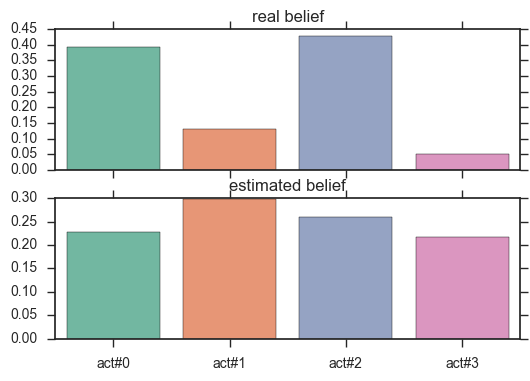

In [41]:
compare_belief(belief, est_rho, actscats)

### Comparing real & simulated observation distributions

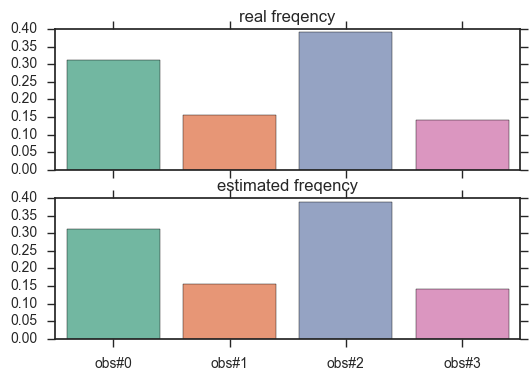

In [42]:
estacts = np.random.choice(range(4), size=K, p=est_rho)
estobs = np.array([observe(act) for act in estacts])
compare_belief(get_freq(obs), get_freq(estobs), obscats, "real freqency", "estimated freqency")

## Recover the whole Equivalence Class

In [43]:
def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

In [44]:
eta = nullspace(emission)

### Comparing real belief & some of the equivent belief to the MLE

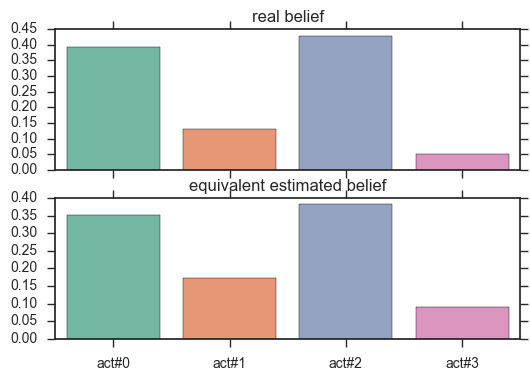

In [47]:
equiv_rho = est_rho + 0.25*eta.squeeze()
compare_belief(belief, equiv_rho, actscats, name_bottom="equivalent estimated belief")

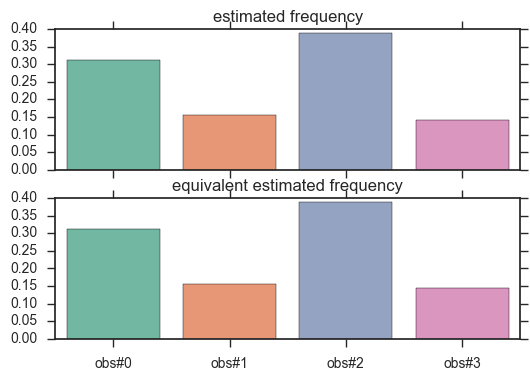

In [48]:
eqvacts = np.random.choice(range(4), size=K, p=equiv_rho)
eqvobs = np.array([observe(act) for act in eqvacts])
compare_belief(get_freq(estobs), get_freq(eqvobs), obscats, "estimated frequency", "equivalent estimated frequency")